In [65]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [66]:
def get_device():
    """Returns the available device for computation.
    Returns:
        torch.device: available device for computation
    """
    compute_device = None
    if torch.cuda.is_available():
        compute_device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        compute_device = torch.device('mps')
    else:
        compute_device = torch.device('cpu')
    
    print(f'device is {compute_device}')
    return compute_device

In [67]:
# device = get_device()
device = torch.device('cpu')
device

device(type='cpu')

In [68]:
rng = np.random.default_rng(73512)

# Dane syntetyczne

In [69]:
indices = np.arange(0, 50, 0.02)
synthetic_data = (np.sin(indices * 3) + indices / 10 + (indices / 10) ** 2 + np.sin(indices * 10)) #/ np.exp(indices / 20)

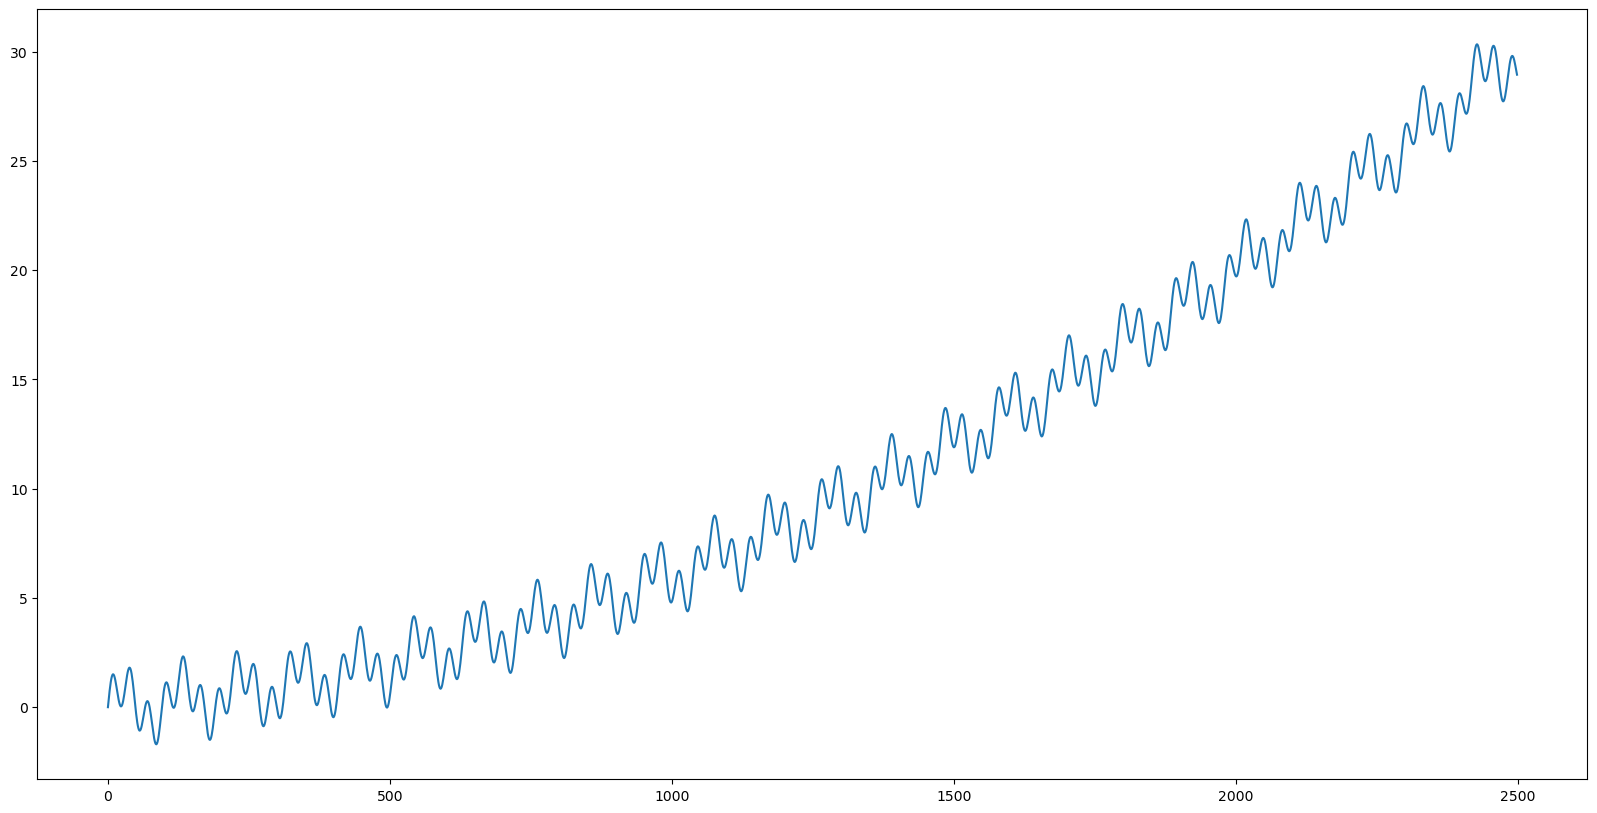

In [70]:
plt.figure(figsize=[20, 10])
plt.plot(synthetic_data)
plt.show()

In [71]:
min_value = synthetic_data.min()
max_value = synthetic_data.max()

In [72]:
data_seq = []
data_targets = []
sequence_len = 150
for i in range(len(synthetic_data) - sequence_len - 1):
    data_seq.append(torch.from_numpy(synthetic_data[i:i + sequence_len]))
    data_targets.append(synthetic_data[i + sequence_len + 1])

In [73]:
data = (torch.stack(data_seq).float() - min_value) / max_value
data_targets = (torch.Tensor(data_targets).float() - min_value) / max_value
train_indices = rng.random(len(data_seq)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_data, test_targets = data[test_indices], data_targets[test_indices]

In [74]:
class SimpleRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
model = SimpleRegressor(sequence_len, 5, 1).to(device)
model

SimpleRegressor(
  (linear1): Linear(in_features=150, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [76]:
model.train() 

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00376
Epoch: 10, loss: 0.0024
Epoch: 20, loss: 0.00046
Epoch: 30, loss: 7.85e-05
Epoch: 40, loss: 0.000187
Epoch: 50, loss: 3.52e-05
Epoch: 60, loss: 0.000291
Epoch: 70, loss: 0.000146
Epoch: 80, loss: 9.61e-05
Epoch: 90, loss: 2.95e-05
Epoch: 100, loss: 3.99e-05


In [77]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze()-test_targets.to(device)).mean())

tensor(0.0064)


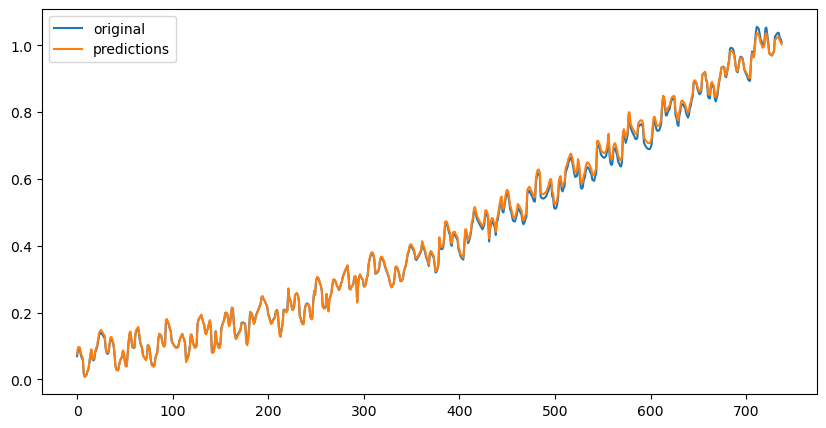

In [78]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label='original')
plt.plot(test_preds.cpu().numpy(), label='predictions')
plt.legend()
plt.show()

## Koniec laborki?

### Co poszło nie tak?

In [79]:
train_split = int(len(data) * 0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [80]:
model = SimpleRegressor(sequence_len, 5, 1).to(device)
model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00185
Epoch: 10, loss: 5.22e-05
Epoch: 20, loss: 6.21e-05
Epoch: 30, loss: 7.11e-05
Epoch: 40, loss: 0.000109
Epoch: 50, loss: 8.1e-05
Epoch: 60, loss: 4.81e-05
Epoch: 70, loss: 1.24e-05
Epoch: 80, loss: 3.03e-05
Epoch: 90, loss: 4.4e-05
Epoch: 100, loss: 2.45e-05


In [81]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.1190)


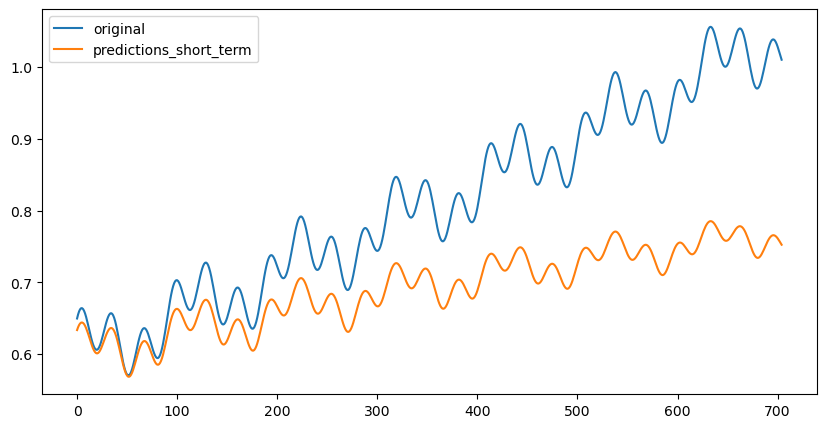

In [82]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label='original')
plt.plot(test_preds.cpu().numpy(), label='predictions_short_term')
plt.legend()
plt.show()

# Sieć rekurencyjna

In [83]:
class RecurrentRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, num_state):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs + num_state, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear_out = nn.Linear(num_hidden, num_outputs)
        self.linear_state = nn.Linear(num_hidden, num_state)

    def forward(self, x, state):
        x = torch.cat([x, state], 1)
        x = self.linear1(x)
        x = self.act_fn(x)
        out = self.linear_out(x)
        state = self.linear_state(x)
        return out, state
    
model = RecurrentRegressor(1, 5, 1, 5).to(device)
model

RecurrentRegressor(
  (linear1): Linear(in_features=6, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (linear_state): Linear(in_features=5, out_features=5, bias=True)
)

### Dokończ pętlę uczącą poniżej:

In [84]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        loss_total = 0
        state = torch.zeros(len(x), 5).to(device)
        optimizer.zero_grad() 
        for i in range(x.size(1)):
            ### Co tutaj?
            x_one = x[:, i].unsqueeze(1)
            if i < sequence_len - 1:
                target = x[:, i+1]
            else:
                target = targets
            y_pred, state = model.forward(x_one, state)
            y_pred = y_pred.squeeze(dim=1)
            loss = loss_fun(y_pred, target)
            loss_total += loss
        loss_total.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.672
Epoch: 10, loss: 0.0266
Epoch: 20, loss: 0.000872
Epoch: 30, loss: 0.000458
Epoch: 40, loss: 0.000294
Epoch: 50, loss: 0.000231
Epoch: 60, loss: 0.000209
Epoch: 70, loss: 0.000199
Epoch: 80, loss: 0.000181
Epoch: 90, loss: 0.000149
Epoch: 100, loss: 0.000117


In [85]:
with torch.no_grad():
    state = torch.zeros(len(test_data), 5).to(device)
    test_preds = []
    for i in range(test_data.size(1)):
        x_one = test_data[:, i].unsqueeze(1).to(device)
        preds, state = model(x_one, state)
    test_preds.append(preds)
    print(torch.abs((torch.cat(test_preds).squeeze() - test_targets.to(device))).mean())

tensor(0.0506)


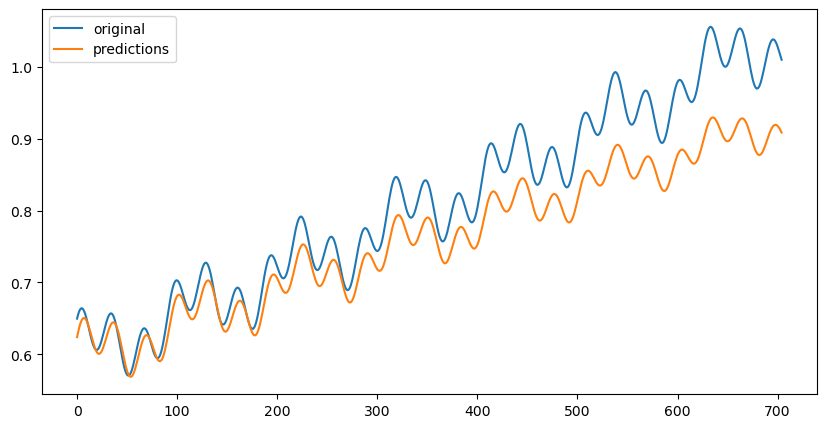

In [86]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(torch.cat(test_preds).squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

# Sieci rekurencyjne w Torchu

In [87]:
batch_size = 2
input_size = 3
hidden_size = 4
num_layers = 2
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=False) #batch_first=False is default!!
rnn

RNN(3, 4, num_layers=2)

In [88]:
with torch.no_grad():
    sequence_len = 5
    x = torch.randn(sequence_len, batch_size, input_size)
    h0 = torch.randn(num_layers, batch_size, hidden_size)
    output, hn = rnn(x, h0)
output

tensor([[[-0.0839,  0.7338, -0.5284, -0.0749],
         [ 0.0913, -0.0545, -0.1260, -0.8138]],

        [[ 0.4277,  0.0698,  0.0418, -0.1734],
         [-0.4893,  0.6881,  0.4548, -0.5836]],

        [[-0.1662,  0.4974,  0.4716, -0.5596],
         [-0.0508,  0.3848, -0.1238, -0.5490]],

        [[ 0.1395,  0.1128, -0.3410, -0.2889],
         [-0.1891,  0.6485,  0.3727, -0.4833]],

        [[ 0.3962,  0.0072, -0.0101,  0.3281],
         [ 0.1560,  0.1334, -0.3396, -0.3748]]])

In [89]:
output[-1]

tensor([[ 0.3962,  0.0072, -0.0101,  0.3281],
        [ 0.1560,  0.1334, -0.3396, -0.3748]])

In [90]:
hn

tensor([[[ 0.5751,  0.5299,  0.1536,  0.0754],
         [ 0.4120,  0.2756,  0.4613, -0.5066]],

        [[ 0.3962,  0.0072, -0.0101,  0.3281],
         [ 0.1560,  0.1334, -0.3396, -0.3748]]])

In [91]:
class RNNRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden
    
    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.rnn(x, hidden)  # hidden - aktualny stan sieci
        out = all_outputs[-1] # We are interested only in the last output
        x = self.fc(out)
        return x, hidden
    
model = RNNRegressor(1, 5, 2, 1).to(device)
model

RNNRegressor(
  (rnn): RNN(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [92]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0552
Epoch: 10, loss: 0.0565
Epoch: 20, loss: 0.0103
Epoch: 30, loss: 0.00216
Epoch: 40, loss: 0.000765
Epoch: 50, loss: 0.000437
Epoch: 60, loss: 0.000294
Epoch: 70, loss: 0.000254
Epoch: 80, loss: 0.000213
Epoch: 90, loss: 0.000172
Epoch: 100, loss: 0.000138


In [93]:
with torch.no_grad():
    hidden = model.init_hidden(len(test_data)).to(device)
    test_preds, _ = model(test_data.to(device).unsqueeze(2),hidden)
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.1128)


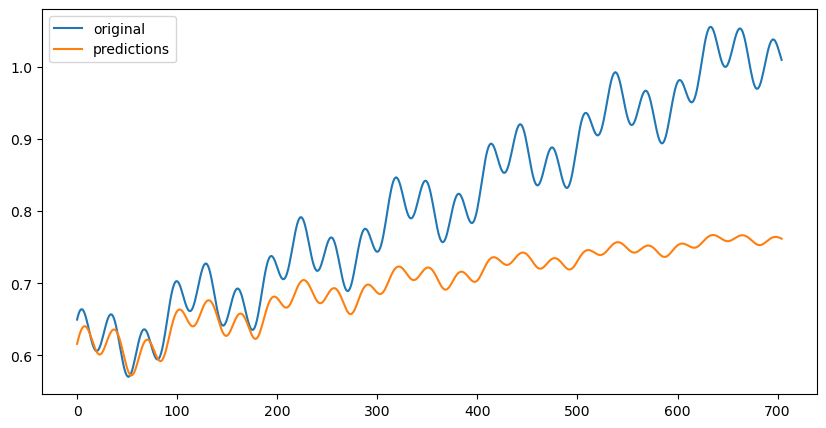

In [94]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(test_preds.squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

## Czy możemy jakoś rozdzielić krótką i długą pamięć?

![LSTM](https://cdn-images-1.medium.com/max/1000/1*Ht2-sUJHi65wDwnR276k3A.png)

In [95]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, hidden_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [96]:
print(output.size())
output

torch.Size([5, 3, 2])


tensor([[[ 0.2006,  0.3001],
         [ 0.0120,  0.4692],
         [-0.2953,  0.4794]],

        [[ 0.2019,  0.2608],
         [ 0.1392,  0.1523],
         [-0.1004,  0.3937]],

        [[ 0.1038,  0.3928],
         [ 0.1240,  0.2491],
         [-0.0422,  0.3276]],

        [[ 0.2046,  0.2535],
         [ 0.1555,  0.2657],
         [ 0.0070,  0.3641]],

        [[ 0.2077,  0.2633],
         [ 0.2234,  0.1941],
         [ 0.0305,  0.3878]]], grad_fn=<StackBackward0>)

In [97]:
print(hn)
print(cn)

tensor([[[0.2077, 0.2633],
         [0.2234, 0.1941],
         [0.0305, 0.3878]]], grad_fn=<StackBackward0>)
tensor([[[0.4663, 0.7306],
         [0.4463, 0.5446],
         [0.0899, 1.2109]]], grad_fn=<StackBackward0>)


In [98]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        out = all_outputs[-1] # We are interested only in the last output
        x = self.fc(out)
        return x, hidden
    
model = LSTMRegressor(1, 20, 2, 1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 20, num_layers=2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00106
Epoch: 10, loss: 0.000524
Epoch: 20, loss: 0.000392
Epoch: 30, loss: 0.000301
Epoch: 40, loss: 0.000149
Epoch: 50, loss: 4.42e-05
Epoch: 60, loss: 3.3e-05
Epoch: 70, loss: 2.14e-05
Epoch: 80, loss: 8.09e-06
Epoch: 90, loss: 2.33e-05
Epoch: 100, loss: 3.81e-05


In [100]:
with torch.no_grad():
    hidden, state = model.init_hidden(test_data.size(0))
    hidden, state = hidden.to(device), state.to(device) 
    test_preds, _ = model(test_data.to(device).unsqueeze(2), (hidden, state))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean().item())

0.03974003717303276


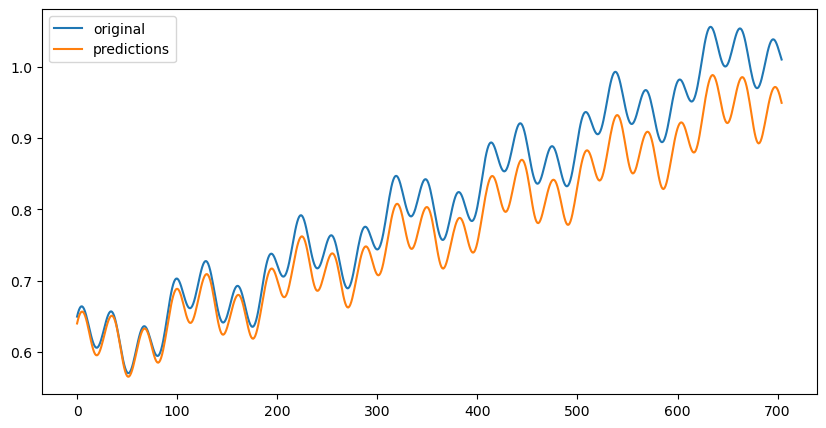

In [101]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(test_preds.squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

### Mini zadanie: Jak wyglądałyby predykcje w oparciu o poprzednie predykcje?

# Predykcja Sequence to sequence

In [ ]:
stock_price = pd.read_csv("https://www.galera.ii.pw.edu.pl/~kdeja/data/all_stocks_5yr.csv")

In [ ]:
mastercard_stock = stock_price[stock_price.Name=="MA"].open.values
visa_stock = stock_price[stock_price.Name=="V"].open.values

In [ ]:
plt.figure(figsize=[10, 5])
plt.plot(mastercard_stock, label='mastercard')
plt.plot(visa_stock, label='visa')
plt.legend()
plt.show()

In [ ]:
m_min_value = mastercard_stock.min()
m_max_value = mastercard_stock.max()
v_min_value = visa_stock.min()
v_max_value = visa_stock.max()

In [ ]:
data_seq = []
data_targets = []
sequence_len = 50
for i in range(len(mastercard_stock) - sequence_len):
    data_seq.append(torch.from_numpy(mastercard_stock[i:i + sequence_len]))
    data_targets.append(torch.from_numpy(visa_stock[i:i + sequence_len]))
    
data = (torch.stack(data_seq).float() - m_min_value) / m_max_value
data_targets = (torch.stack(data_targets).float() - v_min_value) / v_max_value    

train_split = int(len(data) * 0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [ ]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
projection_size = 1

lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, proj_size=projection_size)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, projection_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [ ]:
output

In [ ]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size=out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1, 50, 2, 1).to(device)
model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(2)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

In [ ]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    for i in range(0, len(test_targets), sequence_len):
        hidden, state = model.init_hidden(1)
        hidden, state = hidden.to(device), state.to(device) 
        selected_test_targets.append(test_targets[i])
        pred, _ = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden, state))
        preds.append(pred.squeeze())

In [ ]:
plt.figure(figsize=[10, 5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label='original')
plt.plot(torch.cat(preds).cpu().numpy(), label='predicted')
plt.legend()
plt.show()

### Co się stało, skąd takie dziwne predykcje?

W kazdej iteracji inicjalizujemy od nowa stan, przez co nie mamy zachowanej ciągłości. Musimy to przenieść ponad pętlę

In [ ]:
# ???

with torch.no_grad():
    selected_test_targets = []
    preds = []
    hidden, state = model.init_hidden(1)
    for i in range(0, len(test_targets), sequence_len):
        hidden, state = hidden.to(device), state.to(device) 
        selected_test_targets.append(test_targets[i])
        pred, _ = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden, state))
        preds.append(pred.squeeze())

# Klasyfikacja serii

Np klasyfikacja utworów po ich dzwięku

In [ ]:
libras = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data", header=None)

In [ ]:
libras.head()

In [ ]:
classes = libras[90].values
data = libras.values[:, :-1]

In [ ]:
data = torch.from_numpy(data).float()
data_targets = torch.from_numpy(classes).long()

train_indices = rng.random(len(data)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32)
test_data, test_targets = data[test_indices], data_targets[test_indices]

### Napisz klasyfikator

# Dane o różnej długości

In [ ]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [ ]:
min_gen_val = 10
max_gen_val = 1001
samples = 1000
max_gen_len = 32

data = []
targets = []
max_val = -1
for _ in range(samples):
    seq_len = rng.integers(low=1, high=max_gen_len, size=1)
    data_in = rng.integers(low=min_gen_val, high=max_gen_val, size=seq_len)
    data_sum = np.array([data_in[:i + 1].sum() for i in range(len(data_in))])
    data.append(torch.from_numpy(data_in))
    targets.append(torch.from_numpy(data_sum))
    max_val = data_sum[-1] if data_sum[-1] > max_val else max_val

In [ ]:
train_indices = int(len(data) * 0.7)
data = [(x / max_val).float() for x in data]
targets = [(x / max_val).float() for x in targets]
train_set = VariableLenDataset(data[:train_indices], targets[:train_indices])
test_set = VariableLenDataset(data[train_indices:], targets[train_indices:])

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [ ]:
train_loader = DataLoader(train_set, batch_size=50, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=50, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [ ]:
print(len(train_set[0][0]))
print(len(train_set[1][0]))

In [ ]:
next(iter(train_loader))

In [ ]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size = out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        # x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        # all_outputs = torch.transpose(all_outputs, 0, 1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1, 200, 1, 1).to(device)
model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        
        x = torch.transpose(x, 0, 1)
        preds, _ = model(x, (hidden, state))
        preds = torch.transpose(preds, 0, 1)
        
#         x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
#         preds_packed, _ = model(x_packed, (hidden, state))
#         preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        preds = preds.squeeze(2)
        optimizer.zero_grad()
        mask = targets != pad
        loss = loss_fun(preds[mask], targets[mask])
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

In [ ]:
with torch.no_grad():
    for x, targets, x_len, target_len in test_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.shape[0])
        hidden, state = hidden.to(device), state.to(device)
        
        x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        preds_packed, _ = model(x_packed, (hidden, state))
        preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        preds = preds.squeeze(2)
        mask_tgt = targets != pad
        print(targets)
        print(preds)
        print(torch.abs(preds[mask_tgt] - targets[mask_tgt]).mean())
        print()